In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


# Data processing

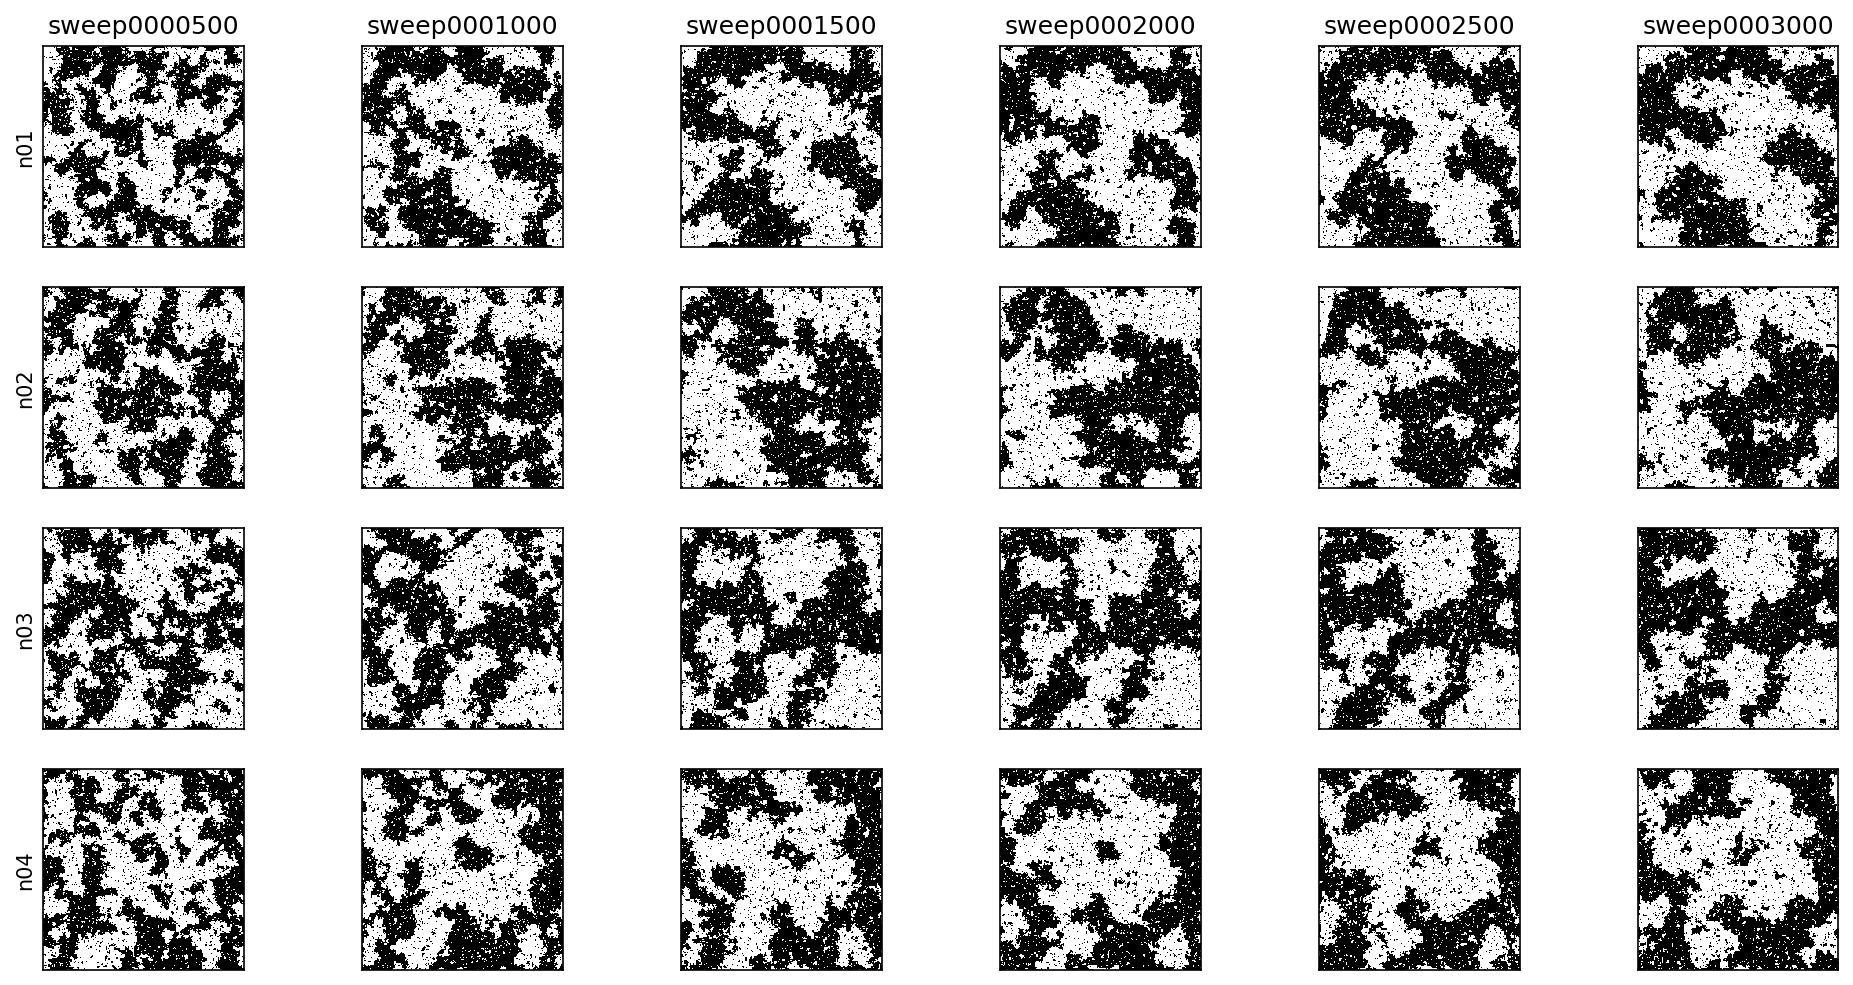

In [2]:
from tqdm import tqdm
from glob import glob
import json
import os

data_dir = '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data'
folders = sorted(glob(f'{data_dir}/n*'))

fig, ax = plt.subplots(4,6, dpi=150, figsize=(16,8))

for i in range(4):
    data_files = sorted(glob(f'{folders[i]}/sweep*.npy'))
    for j in range(6):
        frame_num = j + 1
        data = np.load(data_files[frame_num], mmap_mode='r')
        ax[i,j].imshow(data, cmap='Greys', interpolation='None', vmin=-1, vmax=1)
        ax[i,j].set(xticks=[], yticks=[])
        
        ax[0,j].set_title(os.path.basename(data_files[frame_num])[:-4])
    ax[i,0].set_ylabel(os.path.basename(folders[i]))

193
x (256, 256)
y (256, 256)
dt 1
t (5,)
phi torch.Size([5, 1, 256, 256])


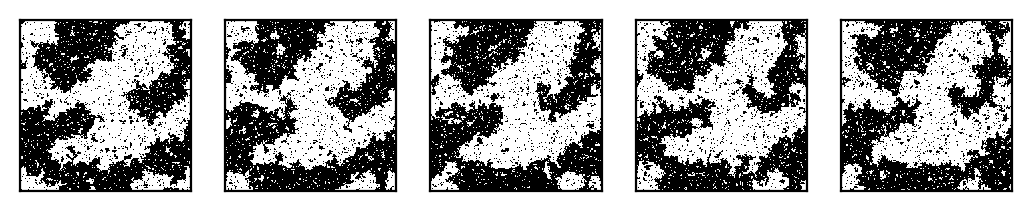

In [17]:
from forecasting_dataset import SimulationDataset

ds = SimulationDataset(f'{data_dir}/n01')
print(len(ds))

sample = ds[5]
for key in sample:
    try:
        print(key, sample[key].shape)
    except:
        print(key, sample[key])

fig, ax = plt.subplots(1, len(sample['t']), dpi=200)

for i in range(len(ax)):
    ax[i].pcolormesh(sample['x'], sample['y'], sample['phi'][i].squeeze(), cmap='Greys')
    ax[i].set(xticks=[], yticks=[], aspect='equal')

# Simulating a trained model

{'accumulate_grad_batches': 8,
 'batch_size': 2,
 'n_epochs': 200,
 'savename': 'models/SimulationForecasting_1',
 'train_folder': ['/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n19',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n16',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n06',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n01',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n17',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n15',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n15',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n08',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n09',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n04',
                  '/project/vitelli/dsseara/ising/2024-04-15_kawasaki/data/n

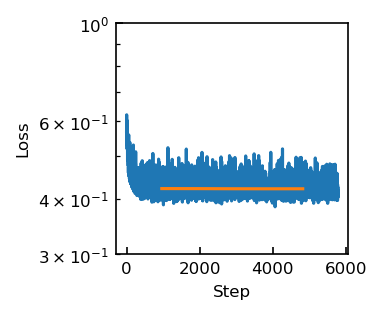

In [45]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting
from pprint import pprint

device = torch.device('cuda:0')
model_path = 'models/SimulationForecasting_1'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
pprint(info)

val_set_size = len(info['val_folder']) * 193 / 2

folder = info['val_folder'][1]
print(f'Predicting using validation folder {os.path.basename(folder)}')
ds = SimulationDataset(folder, seq_len=25)

# Load model
info = torch.load(f'{model_path}.ckpt')
info["val_loss"] = np.array(info["val_loss"]) / val_set_size
print(f'Model reached train loss of {np.min(info["train_loss"])} and val loss of {np.min(info["val_loss"])}')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

val_step = np.arange(1, len(info["val_loss"]) + 1) * val_set_size

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(2, 2))
ax.plot(info["train_loss"])
ax.plot(val_step, info["val_loss"])
ax.tick_params(which='both', direction='in')
ax.set(xlabel='Step', ylabel='Loss', yscale='log', ylim=[3e-1, 1e0])

sample = ds[2]
with torch.no_grad():
    phi1 = model.simulate(sample['phi'][0:1].to(device), ds.seq_len)[0].detach().cpu().numpy().squeeze()

logits = 0.5 * (1 + phi1)
randoms = np.random.uniform(size=phi1.shape)
preds = np.zeros_like(phi1)
preds[randoms < logits] = 1
preds[randoms >= logits] = -1

Text(0, 0.5, 'Error')

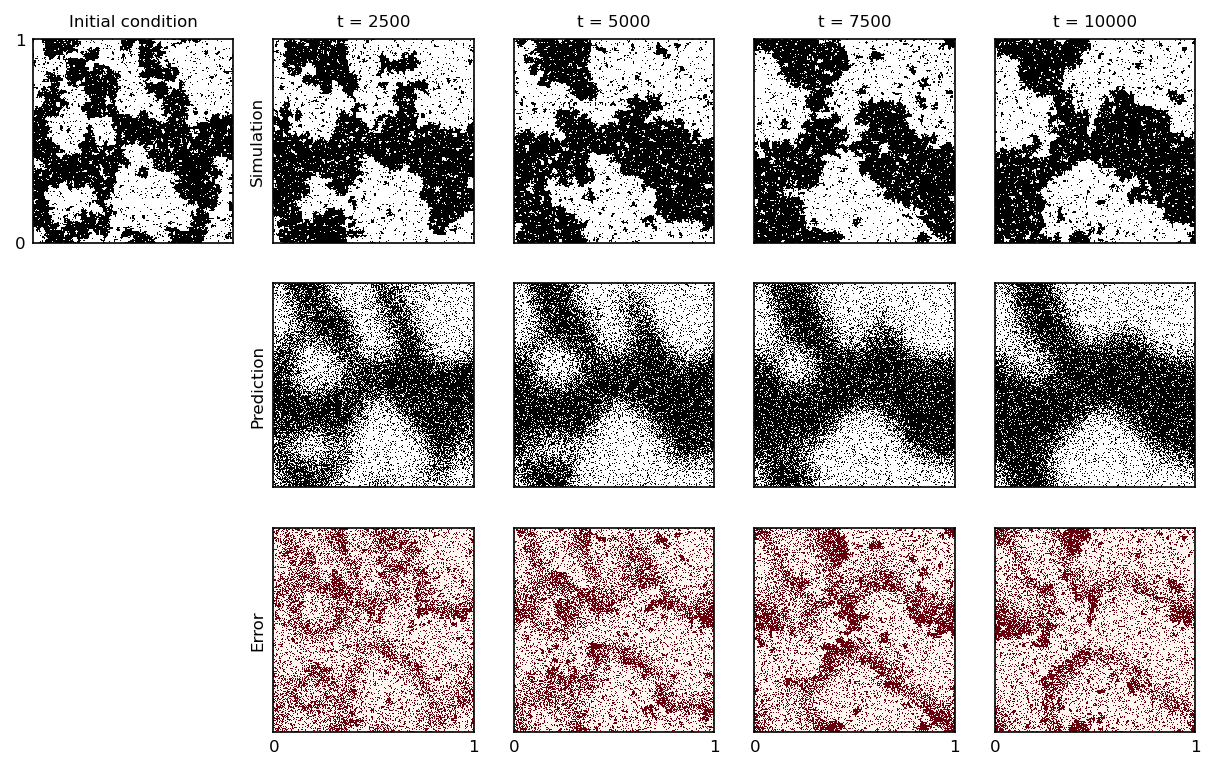

In [46]:
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8

fig, ax = plt.subplots(3, 5, figsize=(10, 6), dpi=200, sharex=True, sharey=True)
dt = 5
kwargs = dict(cmap='Greys', vmin=-1, vmax=1)
for i in range(5):
    ax[0,i].pcolormesh(sample['x'], sample['y'], sample['phi'][i*dt].squeeze(), **kwargs)
    if i > 0:
        ax[1,i].pcolormesh(sample['x'], sample['y'], preds[i*dt], **kwargs)

        err = np.abs(preds[i*dt] - sample['phi'][i*dt].squeeze().numpy())
        ax[2,i].pcolormesh(sample['x'], sample['y'], err, cmap='Reds', vmin=0, vmax=2)
        
        ax[0,i].set_title(f't = {i*dt*500}')        

ax[0,0].set_title('Initial condition')
ax[1,0].axis('off')
ax[2,0].axis('off')

for a in ax.flatten():
    a.set(xticks=[0, 1], yticks=[0, 1])
    a.tick_params(which='both', length=0)

ax[0,1].set_ylabel('Simulation')
ax[1,1].set_ylabel('Prediction')
ax[2,1].set_ylabel('Error')

Text(0.5, 1.0, 'Prediction')

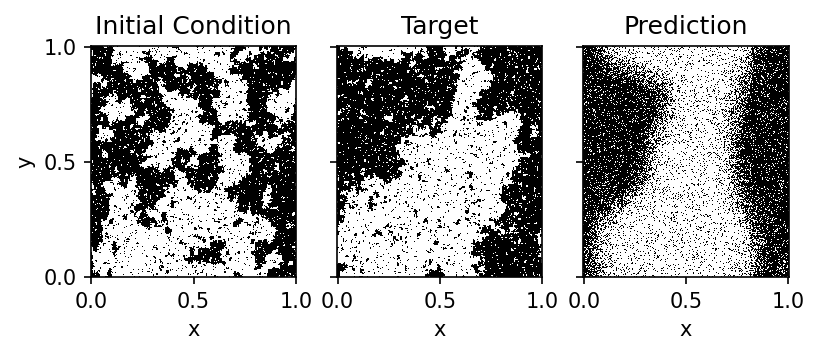

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2), dpi=150, sharex=True, sharey=True)

ax[0].pcolormesh(sample['x'], sample['y'], sample['phi'][0].squeeze(), cmap='Grays', vmin=-1, vmax=1)
ax[1].pcolormesh(sample['x'], sample['y'], sample['phi'][-1].squeeze(), cmap='Grays', vmin=-1, vmax=1)
ax[2].pcolormesh(sample['x'], sample['y'], preds[-1], cmap='Grays', vmin=-1, vmax=1)

for a in ax:
    a.set(xticks=[0, 0.5, 1], yticks=[0, 0.5, 1], xlabel='x')
ax[0].set_ylabel('y')

ax[0].set_title('Initial Condition')
ax[1].set_title('Target')
ax[2].set_title('Prediction')